In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# import packages
import pandas as pd
import os
from copy import deepcopy
from edisgo.edisgo import import_edisgo_from_files
from edisgo import EDisGo
#from edisgo.tools.tools import assign_feeder_ids

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning:

Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning:

Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?



In [8]:
grid_ids = [2534, 1811, 1690, 177, 176, 1056]
root_dir = r'U:\Software'

edisgo_objects = {}

for grid_id in grid_ids:
    edisgo_dir = root_dir + r'\eDisGo_object_files\simbev_nep_2035_results\{}\reduced'.format(grid_id)
    edisgo_objects[grid_id] = import_edisgo_from_files(edisgo_dir, import_timeseries=True)

In [10]:
for grid_id in grid_ids:
    print('Grid {} with {} buses and {} charging_points'.format(grid_id, len(edisgo_objects[grid_id].topology.buses_df), 
      len(edisgo_objects[grid_id].topology.charging_points_df)))

Grid 2534 with 9592 buses and 1444 charging_points
Grid 1811 with 17972 buses and 1864 charging_points
Grid 1690 with 13962 buses and 1456 charging_points
Grid 177 with 20258 buses and 2720 charging_points
Grid 176 with 30542 buses and 3319 charging_points
Grid 1056 with 12766 buses and 1584 charging_points


In [12]:
for grid_id in grid_ids:
    print('Grid {} with {} MV buses and {} LV buses'.format(grid_id, len(edisgo_objects[grid_id].topology.mv_grid.buses_df), 
      len(edisgo_objects[grid_id].topology.buses_df)-len(edisgo_objects[grid_id].topology.mv_grid.buses_df)))

Grid 2534 with 94 MV buses and 9493 LV buses
Grid 1811 with 800 MV buses and 17147 LV buses
Grid 1690 with 430 MV buses and 13532 LV buses
Grid 177 with 148 MV buses and 20098 LV buses
Grid 176 with 284 MV buses and 30243 LV buses
Grid 1056 with 252 MV buses and 12505 LV buses


U:\Software\eDisGo_mirror\edisgo\tools\plots.py:593: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ][edisgo_obj.topology.lines_df.bus1.isin(pypsa_plot.buses.index)].loc[


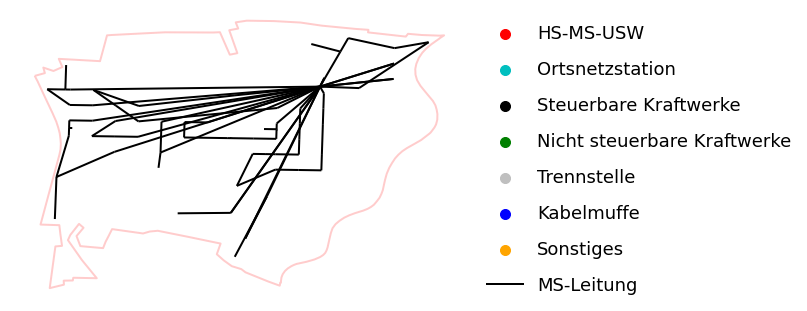

In [12]:
edisgo_objects[2534].plot_mv_grid_topology()

U:\Software\eDisGo_mirror\edisgo\tools\plots.py:593: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ][edisgo_obj.topology.lines_df.bus1.isin(pypsa_plot.buses.index)].loc[


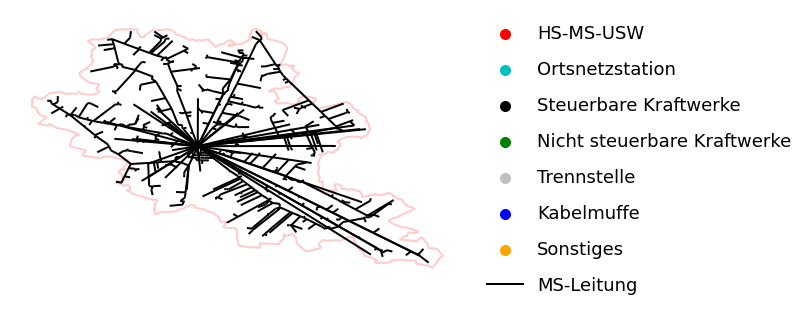

In [11]:
edisgo_objects[1811].plot_mv_grid_topology()

U:\Software\eDisGo_mirror\edisgo\tools\plots.py:593: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ][edisgo_obj.topology.lines_df.bus1.isin(pypsa_plot.buses.index)].loc[


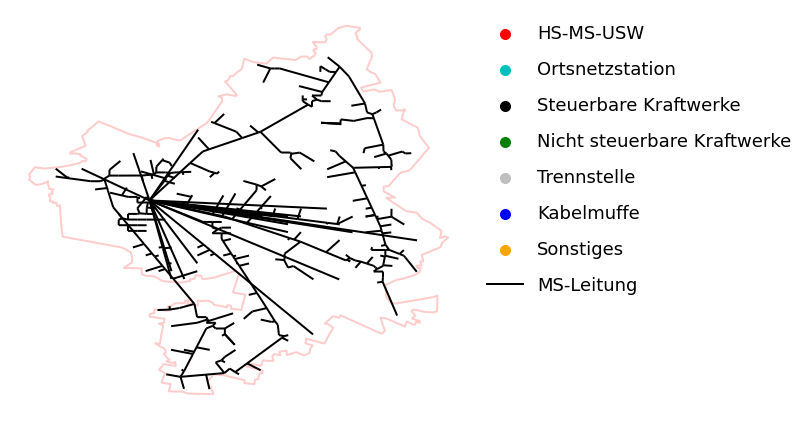

In [13]:
edisgo_objects[1690].plot_mv_grid_topology()

U:\Software\eDisGo_mirror\edisgo\tools\plots.py:593: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ][edisgo_obj.topology.lines_df.bus1.isin(pypsa_plot.buses.index)].loc[


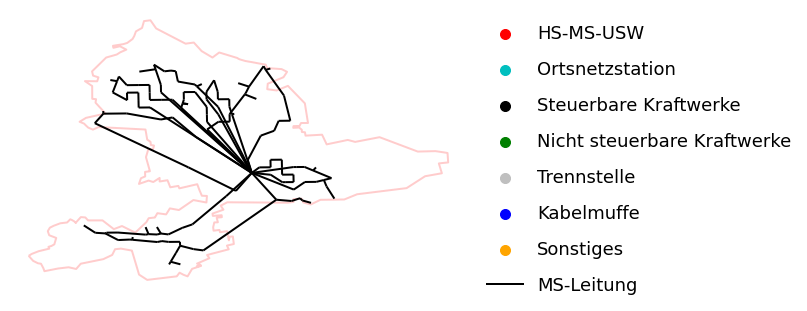

In [14]:
edisgo_objects[177].plot_mv_grid_topology()

U:\Software\eDisGo_mirror\edisgo\tools\plots.py:593: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ][edisgo_obj.topology.lines_df.bus1.isin(pypsa_plot.buses.index)].loc[


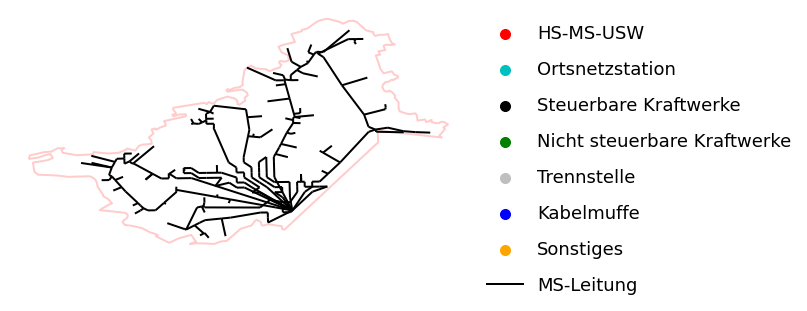

In [15]:
edisgo_objects[176].plot_mv_grid_topology()

U:\Software\eDisGo_mirror\edisgo\tools\plots.py:593: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ][edisgo_obj.topology.lines_df.bus1.isin(pypsa_plot.buses.index)].loc[


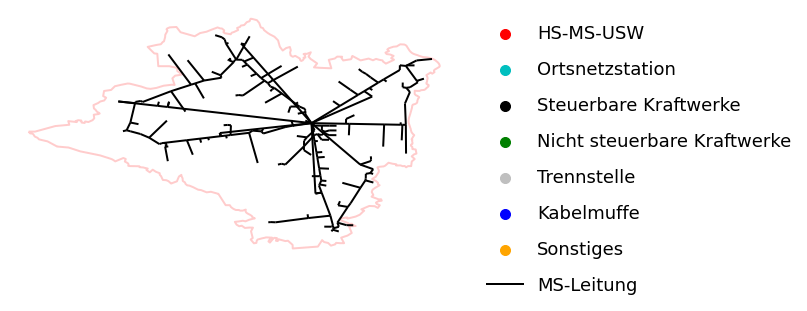

In [16]:
edisgo_objects[1056].plot_mv_grid_topology()

# Extract single feeders

In [57]:
def assign_feeder_ids(edisgo_obj, start_buses, station_bus):
    feeder_id = 0
    visited_buses = [station_bus]
    for bus in start_buses:
        if bus not in visited_buses:
            buses_df, visited_buses_tmp = get_feeders_from_substation(
                bus, edisgo_obj.topology.buses_df, edisgo_obj.topology.lines_df, feeder_id, visited_buses)
            visited_buses.extend(visited_buses_tmp)
            feeder_id += 1
    return buses_df


def get_feeders_from_substation(initial_bus, buses_df, lines_df, feeder_id, visited_buses):
    # initialisation
    current_bus = initial_bus
    return deep_search_for_lv_feeder_assignment(buses_df, current_bus,
                                                lines_df, feeder_id,
                                                visited_buses)


def deep_search_for_lv_feeder_assignment(buses_df, current_bus, lines_df,
                                         feeder_id, visited_buses):
    # iteration
    # set feeder id of current bus and append to visited buses
    buses_df.loc[current_bus, 'feeder_id'] = int(feeder_id)
    visited_buses.append(current_bus)
    # get neighboring buses that have not been visited yet
    connected_branches = lines_df.loc[lines_df.bus0 == current_bus].append(
        lines_df.loc[lines_df.bus1 == current_bus])
    connected_buses = connected_branches.bus0.append(connected_branches.bus1)
    neighbors_not_visited = connected_buses[~connected_buses.isin(
        visited_buses)].values
    for bus in neighbors_not_visited:
        buses_df, visited_buses = deep_search_for_lv_feeder_assignment(
            buses_df, bus, lines_df, feeder_id, visited_buses)
    return buses_df, visited_buses

In [17]:
edisgo_obj = edisgo_objects[176]

In [18]:
edisgo_obj.topology.mv_grid.station

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building
Busbar_mvgd_176_MV,20,8.64463,48.1454,176,NaN,False


In [25]:
feeder_lines = edisgo_obj.topology.lines_df.loc[edisgo_obj.topology.lines_df.bus0==edisgo_obj.topology.mv_grid.station.index[0]].append(
edisgo_obj.topology.lines_df.loc[edisgo_obj.topology.lines_df.bus1==edisgo_obj.topology.mv_grid.station.index[0]])

In [51]:
feeder_buses = list(feeder_lines.bus0.unique())+list(feeder_lines.bus1.unique())
feeder_buses=list(filter(lambda x: x != edisgo_obj.topology.mv_grid.station.index[0], feeder_buses))
feeder_buses

['BranchTee_Branch_LVStation_mvgd_176_lvgd_24418_MVStation_mvgd_176',
 'BusBar_mvgd_176_lvgd_24359_MV',
 'BusBar_mvgd_176_lvgd_24377_MV',
 'BusBar_mvgd_176_lvgd_24384_MV',
 'BusBar_mvgd_176_lvgd_24391_MV',
 'BusBar_mvgd_176_lvgd_24398_MV',
 'BusBar_mvgd_176_lvgd_24401_MV',
 'BusBar_mvgd_176_lvgd_24407_MV',
 'BusBar_mvgd_176_lvgd_24411_MV',
 'BusBar_mvgd_176_lvgd_24422_MV',
 'BusBar_mvgd_176_lvgd_24423_MV',
 'BusBar_mvgd_176_lvgd_24425_MV',
 'BusBar_mvgd_176_lvgd_24432_MV',
 'BusBar_mvgd_176_lvgd_24435_MV']

In [59]:
branches = pd.concat([edisgo_obj.topology.lines_df, edisgo_obj.topology.transformers_df])
buses_with_feeders = assign_feeder_ids(edisgo_obj, feeder_buses, edisgo_obj.topology.mv_grid.station.index[0])
buses_with_feeders

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


KeyboardInterrupt: 

In [60]:
buses_with_feeders

[autoreload of edisgo.tools.tools failed: Traceback (most recent call last):
  File "c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\users\aheider\.conda\envs\edisgo_env\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "c:\users\aheider\.conda\envs\edisgo_env\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_remo

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building,feeder_id
name,,,,,,,
Busbar_mvgd_176_MV,20.0,8.644626,48.145372,176,NaN,False,NaN
BusBar_mvgd_176_lvgd_400171_MV,20.0,8.564328,48.137242,176,NaN,False,5.0
BusBar_mvgd_176_lvgd_400621_MV,20.0,8.585118,48.137524,176,NaN,False,5.0
BusBar_mvgd_176_lvgd_400692_MV,20.0,8.588624,48.139197,176,NaN,False,5.0
BusBar_mvgd_176_lvgd_401054_MV,20.0,8.604967,48.140808,176,NaN,False,5.0
BusBar_mvgd_176_lvgd_15433_MV,20.0,8.543571,48.143440,176,NaN,False,7.0
BusBar_mvgd_176_lvgd_16692_MV,20.0,8.590958,48.127855,176,NaN,False,5.0
BusBar_mvgd_176_lvgd_400993_MV,20.0,8.601743,48.128927,176,NaN,False,5.0
BusBar_mvgd_176_lvgd_400620_MV,20.0,8.585342,48.129427,176,NaN,False,5.0


In [61]:
edisgo_obj.topology.mv_grid.lv_grids

<generator object lv_grids at 0x00000188EAEB38E0>

In [62]:
edisgo_obj.topology.mv_grid.station

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building,feeder_id
Busbar_mvgd_176_MV,20,8.64463,48.1454,176,NaN,False,NaN


In [64]:
buses_df=buses_with_feeders
for lv_grid in edisgo_obj.topology.mv_grid.lv_grids:
    trafo = edisgo_obj.topology.transformers_df.loc[edisgo_obj.topology.transformers_df.bus1==lv_grid.station.index[0]]
    buses_df.loc[lv_grid.buses_df.index, 'feeder_id'] = buses_df.loc[trafo.bus0, 'feeder_id'].values[0]

In [66]:
buses_df.feeder_id.unique()

array([nan,  5.,  7., 12.,  1.,  3.,  2.,  4.,  6.,  0., 11.,  8.,  9.,
       13., 10.])

In [68]:
number_of_buses_in_feeders = []
for feeder in buses_df.feeder_id.unique():
    print('Feeder {} with {} buses.'.format(feeder, len(edisgo_obj.topology.buses_df.loc[buses_df.feeder_id==feeder])))
    number_of_buses_in_feeders.append(len(edisgo_obj.topology.buses_df.loc[buses_df.feeder_id==feeder]))

Feeder nan with 0 buses.
Feeder 5.0 with 2084 buses.
Feeder 7.0 with 2029 buses.
Feeder 12.0 with 2937 buses.
Feeder 1.0 with 218 buses.
Feeder 3.0 with 2916 buses.
Feeder 2.0 with 2319 buses.
Feeder 4.0 with 5888 buses.
Feeder 6.0 with 1865 buses.
Feeder 0.0 with 3305 buses.
Feeder 11.0 with 2591 buses.
Feeder 8.0 with 2694 buses.
Feeder 9.0 with 68 buses.
Feeder 13.0 with 1545 buses.
Feeder 10.0 with 82 buses.


In [70]:
sum(number_of_buses_in_feeders)

30541

In [75]:
edisgo_feeder = deepcopy(edisgo_obj)

In [88]:
# convert topology
edisgo_feeder.topology.buses_df = edisgo_obj.topology.buses_df.loc[buses_df.feeder_id==feeder].append(
    edisgo_feeder.topology.mv_grid.station)
edisgo_feeder.topology.lines_df = edisgo_obj.topology.lines_df.loc[edisgo_obj.topology.lines_df.bus0.isin(edisgo_feeder.topology.buses_df.index)].loc[
    edisgo_obj.topology.lines_df.bus1.isin(edisgo_feeder.topology.buses_df.index)]
edisgo_feeder.topology.transformers_df = edisgo_obj.topology.transformers_df.loc[edisgo_obj.topology.transformers_df.bus0.isin(edisgo_feeder.topology.buses_df.index)].loc[
    edisgo_obj.topology.transformers_df.bus1.isin(edisgo_feeder.topology.buses_df.index)]
edisgo_feeder.topology.generators_df = edisgo_obj.topology.generators_df.loc[edisgo_obj.topology.generators_df.bus.isin(edisgo_feeder.topology.buses_df.index)]
edisgo_feeder.topology.loads_df = edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.bus.isin(edisgo_feeder.topology.buses_df.index)]
edisgo_feeder.topology.storage_units_df = edisgo_obj.topology.storage_units_df.loc[edisgo_obj.topology.storage_units_df.bus.isin(edisgo_feeder.topology.buses_df.index)]
edisgo_feeder.topology.charging_points_df = edisgo_obj.topology.charging_points_df.loc[edisgo_obj.topology.charging_points_df.bus.isin(edisgo_feeder.topology.buses_df.index)]
edisgo_feeder.topology.switches_df = edisgo_obj.topology.switches_df.loc[edisgo_obj.topology.switches_df.branch.isin(edisgo_feeder.topology.lines_df.index)]
# convert timeseries
edisgo_feeder.timeseries.charging_points_active_power = edisgo_obj.timeseries.charging_points_active_power[edisgo_feeder.topology.charging_points_df.index]
edisgo_feeder.timeseries.charging_points_reactive_power = edisgo_obj.timeseries.charging_points_reactive_power[edisgo_feeder.topology.charging_points_df.index]
edisgo_feeder.timeseries.generators_active_power = edisgo_obj.timeseries.generators_active_power[edisgo_feeder.topology.generators_df.index]
edisgo_feeder.timeseries.generators_reactive_power = edisgo_obj.timeseries.generators_reactive_power[edisgo_feeder.topology.generators_df.index]
edisgo_feeder.timeseries.loads_active_power = edisgo_obj.timeseries.loads_active_power[edisgo_feeder.topology.loads_df.index]
edisgo_feeder.timeseries.loads_reactive_power = edisgo_obj.timeseries.loads_reactive_power[edisgo_feeder.topology.loads_df.index]
edisgo_feeder.timeseries.storage_units_active_power = edisgo_obj.timeseries.storage_units_active_power[edisgo_feeder.topology.storage_units_df.index]
edisgo_feeder.timeseries.storage_units_reactive_power = edisgo_obj.timeseries.storage_units_reactive_power[edisgo_feeder.topology.storage_units_df.index]

In [102]:
os.makedirs(r'U:\Software\eDisGo_object_files\simbev_nep_2\{}\feeders\{}'.format(grid_id, feeder),exist_ok=True)
edisgo_feeder.save(r'U:\Software\eDisGo_object_files\simbev_nep_2\{}\feeders\{}'.format(grid_id, feeder))

In [85]:
edisgo_obj.topology.lines_df.loc[edisgo_obj.topology.lines_df.bus0.isin(edisgo_feeder.topology.buses_df.index)]

,bus0,bus1,kind,length,num_parallel,r,s_nom,type_info,x
name,,,,,,,,,
Branch_LVStation_mvgd_176_lvgd_24359_MVStation_mvgd_176,Busbar_mvgd_176_MV,BusBar_mvgd_176_lvgd_24359_MV,line,6.947974,1.0,0.416878,23.642494,NA2XS(FL)2Y 3x1x400 RM/35,0.604460
Branch_LVStation_mvgd_176_lvgd_24377_MVStation_mvgd_176,Busbar_mvgd_176_MV,BusBar_mvgd_176_lvgd_24377_MV,line,3.658147,1.0,0.579676,14.365629,NA2XS2Y 3x1x150 RE/25,0.354585
Branch_LVStation_mvgd_176_lvgd_24384_MVStation_mvgd_176,Busbar_mvgd_176_MV,BusBar_mvgd_176_lvgd_24384_MV,line,3.295103,1.0,0.522147,14.365629,NA2XS2Y 3x1x150 RE/25,0.319395
Branch_LVStation_mvgd_176_lvgd_24391_MVStation_mvgd_176,Busbar_mvgd_176_MV,BusBar_mvgd_176_lvgd_24391_MV,line,2.634913,1.0,0.263491,18.778895,NA2XS2Y 3x1x240,0.229041
Branch_LVStation_mvgd_176_lvgd_24398_MVStation_mvgd_176,Busbar_mvgd_176_MV,BusBar_mvgd_176_lvgd_24398_MV,line,1.878866,1.0,0.187887,18.778895,NA2XS2Y 3x1x240,0.163321
Branch_LVStation_mvgd_176_lvgd_24401_MVStation_mvgd_176,Busbar_mvgd_176_MV,BusBar_mvgd_176_lvgd_24401_MV,line,2.668702,1.0,0.266870,18.778895,NA2XS2Y 3x1x240,0.231978
Branch_LVStation_mvgd_176_lvgd_24407_MVStation_mvgd_176,Busbar_mvgd_176_MV,BusBar_mvgd_176_lvgd_24407_MV,line,1.107487,1.0,0.051115,26.929926,NA2XS(FL)2Y 3x1x500 RM/35,0.090996
Branch_LVStation_mvgd_176_lvgd_24411_MVStation_mvgd_176,Busbar_mvgd_176_MV,BusBar_mvgd_176_lvgd_24411_MV,line,3.298981,1.0,0.197939,23.642494,NA2XS(FL)2Y 3x1x400 RM/35,0.287005
Branch_LVStation_mvgd_176_lvgd_24416_LVStation_mvgd_176_lvgd_24423,BusBar_mvgd_176_lvgd_24416_MV,BusBar_mvgd_176_lvgd_24423_MV,line,0.467786,1.0,0.133139,9.456997,48-AL1/8-ST1A,0.133394


In [109]:
tmp = import_edisgo_from_files(r'U:\Software\eDisGo_object_files\simbev_nep_2'+'/{}/feeders/{}'.format(grid_id, feeder),
                               import_timeseries=True)

In [104]:
tmp.analyze()

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-01-08 07:00:00', '2011-01-08 07:15:00',
               '2011-01-08 07:30:00', '2011-01-08 07:45:00',
               '2011-01-08 08:00:00', '2011-01-08 08:15:00',
               '2011-01-08 08:30:00', '2011-01-08 08:45:00',
               '2011-01-08 09:00:00', '2011-01-08 09:15:00',
               ...
               '2011-04-23 04:30:00', '2011-04-23 04:45:00',
               '2011-04-23 05:00:00', '2011-04-23 05:15:00',
               '2011-04-23 05:30:00', '2011-04-23 05:45:00',
              

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037292 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046939 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052983 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031250 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037736 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046935 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052861 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046893 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046874 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037854 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031244 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052929 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046875 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053110 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069036 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046901 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037282 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046937 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053489 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031255 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052967 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068546 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046939 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031246 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.036315 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046874 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037315 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046875 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046884 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031304 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.034811 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046878 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052972 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.051411 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031309 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046884 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037752 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031249 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046875 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053424 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052919 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031313 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031305 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053382 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031253 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037844 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031254 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037301 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046879 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037781 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046956 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050922 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031308 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031297 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069052 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049414 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046884 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031261 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037791 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046936 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047912 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.032311 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046882 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037311 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046879 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037792 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053369 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031296 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037394 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031254 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037737 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031313 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031245 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052978 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031244 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052978 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031307 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031249 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037350 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031247 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052970 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.063017 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031317 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052902 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046893 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031290 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052915 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046880 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037081 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031305 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053120 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031258 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037737 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046933 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046830 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048439 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.071001 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.051502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.041002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.041001 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.058502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.041501 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.042506 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.041001 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.041501 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.041001 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046865 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037293 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031250 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037346 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046884 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031303 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.036264 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046877 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037426 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084169 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052921 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062553 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037308 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046929 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037285 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046938 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.033315 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.064538 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031267 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031301 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037292 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031237 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052913 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031307 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068548 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031318 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031238 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037359 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031256 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031253 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037257 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031309 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037347 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031250 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037289 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031313 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031250 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037351 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031248 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

# Reinforcement costs

In [ ]:
grid_ids = [2534, 1811, 1690, 177, 176, 1056]
strategies = ['no_ev', 'dumb', 'reduced', 'residual', 'optimised']
root_dir = r'U:\Software'

edisgo_objects_costs = {}

for grid_id in grid_ids:
    edisgo_objects_costs[grid_id] = {}
    for strategy in strateges:
        edisgo_dir = root_dir + r'\eDisGo_object_files\simbev_nep_2\{}\reduced'.format(grid_id)
        edisgo_objects_costs[grid_id][strategy] = import_edisgo_from_files(edisgo_dir, import_results=True)

In [9]:
strategy = 'no_ev'
grid_id = 176
tmp=edisgo_objects[grid_id]
results_dir = r'U:\Software\eDisGo_object_files\simbev_nep_2035_results\{}\{}\results_after_reinforcement'.format(
    grid_id, strategy)
tmp.results.from_csv(results_dir, parameters=['grid_expansion_results'])

In [11]:
tmp.plot_mv_line_loading()